In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

### Data

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [40]:
model = Model(m, nh, 10)
pred = model(x_train)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss. Because in Pytorch, Negative log likelihood requires a log(softmax) and not just softmax and you'll see why when you scroll further.

In [8]:
# sum them along the columns. hence dim=-1 or 1.
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

From pytorc docs:  
If keepdim is True, the output tensor is of the same size as input except in the dimension(s) dim where it is of size 1. Otherwise, dim is squeezed (see torch.squeeze()), resulting in the output tensor having 1 (or len(dim)) fewer dimension(s).

In [9]:
sm_pred = log_softmax(pred) # softmax predictions

In [10]:
sm_pred.shape

torch.Size([50000, 10])

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

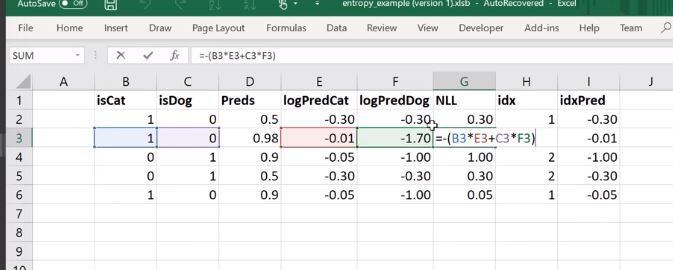

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[0], sm_pred[0][5]

(tensor([-2.3580, -2.3964, -2.3871, -2.2741, -2.2623, -2.3455, -2.2058, -2.4489,
         -2.3328, -2.0709], grad_fn=<SelectBackward>),
 tensor(-2.3455, grad_fn=<SelectBackward>))

Grabbing all 3 predictions at once with the actual y.

In [13]:
sm_pred[[0,1,2], [5,0,4]] # grabs values from 0,5 1,0 and 2,4
# first list is row idxs and second list is the column idxs
# this is called as integer array indexing that pytorch and np support.

tensor([-2.3455, -2.2098, -2.3015], grad_fn=<IndexBackward>)

In [14]:
y_train.shape[0] # no of rows

50000

In [15]:
y_train[:5]# the columns you'll want in your prediction matrix for the respective rows

tensor([5, 0, 4, 1, 9])

Nll is basically the negative of your predictions. All the
rows and (just above) followed by taking the mean of all the values

In [16]:
def nll(input, target):  return -input[range(target.shape[0]), target].mean()

In [17]:
loss = nll(sm_pred, y_train)
loss

tensor(2.2998, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`  
Hint: `(log(x.exp()) = x)`


In [18]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [19]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.  
The reason you need this trick is when you e to the power of x, you can end up getting ridiculously big numbers. Very big numbers in floating point are really inaccurate. So you don't want big numbers when calculating the gradients. This is really helpful numerical stability trick.

In [20]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [21]:
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [22]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [23]:
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation.

In [24]:
pred.shape

torch.Size([50000, 10])

In [25]:
test_near(F.nll_loss(F.log_softmax(pred, dim = -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [27]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [41]:
loss_func = F.cross_entropy

In [42]:
# export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [43]:
bs = 64 # batch size

xb = x_train[0:bs] # mini batch from x
preds = model(xb) # predictions
preds[0], preds.shape

(tensor([ 0.0131, -0.0163,  0.0905, -0.1561,  0.0929, -0.1132,  0.0083, -0.0395,
         -0.2107,  0.0947], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [44]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3066, grad_fn=<NllLossBackward>)

In [45]:
accuracy(preds, yb)

tensor(0.0938)

In [46]:
lr = 0.5
epochs = 1

In [47]:
n

50000

In [48]:
for epoch in range(epochs):
    for i in range(n//bs+ 1):
        start_i  = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'): # check whether that layer has an attribute called 'weight' or not. (relu will not be selected)
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [49]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1354, grad_fn=<NllLossBackward>), tensor(0.9375))

the accuracy here is only for 1 mini batch(xb)

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.  
Everytime you assign to anything inside self in python, python calls the __setattr__ method. The method here just inserts the variables not beginning with '_' in _modules and call it k. And after that just do whatever the super class does when it sets attributes. The superclass here is just object, if it isn't mentioned. If you don't say what it is then its the python highest level object.

In [50]:
class DummyModule():
    def __init__(self, n_in, n, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v): # called everytime when you assign anything inside self(so self.l1 and self.l2 etc)
        #print(k, '\n', v)
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p                    

In [51]:
mdl = DummyModule(m, nh, 10)

In [52]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [55]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

Good news is that Pytorch also has something that does that(__setattr__ part) and its called nn.Module

In [56]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [57]:
model = Model(m, nh, 10)

In [58]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [59]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [60]:
model.l2

Linear(in_features=50, out_features=10, bias=True)

In [61]:
def fit():
    for epoch in range(epochs):
        for i in range((n//bs)+ 1):
            start_i  = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
        
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [62]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2657, grad_fn=<NllLossBackward>), tensor(0.9375))

### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [63]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [69]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
           
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

self.add_module above is just equivalent of self._modules that we defined. It's a method of pytorch.

In [70]:
model = Model(layers)

In [71]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

The for loop w the enumerate above is kinda clunky so it turns out that Pytorch has a fn that does this.(see below)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [72]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x): 
        for l in self.layers: x = l(x)
        return x      

In [73]:
model = SequentialModel(layers)

In [74]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [75]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0541, grad_fn=<NllLossBackward>), tensor(1.))

Even this(__call__ part) is little clunky, 'Why would we have to write it out ourselves; Pytorch has that already

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [76]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [77]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [78]:
nn.Sequential??

In [79]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0354, grad_fn=<NllLossBackward>), tensor(1.))

Refactoring fit() now

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

We shouldn't really say model.zero_grad() because sometimes you might not want all parameters to reset their gradients to zero and so this is why we just go through self.params which is list of parameters you'd wanna do that to.

In [80]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr
                
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [81]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [82]:
opt = Optimizer(model.parameters())

In [83]:
def fit():
    for epoch in range(epochs):
        for i in range((n//bs)+ 1):
            start_i  = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)
        
            loss.backward()
            opt.step()
            opt.zero_grad()

In [84]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1129, grad_fn=<NllLossBackward>), tensor(0.9375))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [85]:
# export 
from torch import optim

In [86]:
optim.SGD??

In [87]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return  model, optim.SGD(model.parameters(), lr = lr)

In [88]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.2941, grad_fn=<NllLossBackward>)

In [89]:
fit()
acc = accuracy(model(xb), yb)
acc

tensor(0.9375)

Randomized tests can be very useful.

In [90]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [91]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [92]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(x_train) == len(train_ds)
assert len(x_valid) == len(valid_ds)

In [93]:
xb, yb = train_ds[:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [94]:
model, opt = get_model()

In [95]:
for epoch in range(epochs):
    for i in range((n//bs) + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [96]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1464, grad_fn=<NllLossBackward>), tensor(0.9375))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

When you go 'for blah in blah' behind scenes python calls __iter__

In [97]:
#export
class Dataloader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+bs]

In [98]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [99]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)

tensor(3)

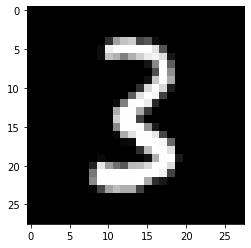

In [100]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [101]:
model,opt = get_model()

In [102]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [103]:
fit()

In [104]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1308, grad_fn=<NllLossBackward>), tensor(0.9844))

In [105]:
epochs

1

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [108]:
torch.randperm(5)

tensor([2, 4, 0, 3, 1])

In [109]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle # not storing the whole dataset bt just its length so that we know how to sample; also, saves space.
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [110]:
small_ds = Dataset(*train_ds[:10])

In [111]:
s = Sampler(small_ds, 3)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [112]:
s = Sampler(small_ds, 3, shuffle=True)
[o for o in s]

[tensor([8, 2, 3]), tensor([9, 6, 7]), tensor([0, 1, 5]), tensor([4])]

In [113]:
def collate(b):
    xs, ys = zip(*b) 
    return torch.stack(xs), torch.stack(ys)

class Dataloader():
    def __init__(self, ds, sampler, collate_fn = collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate
    
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [114]:
train_samp = Sampler(train_ds, bs, shuffle = True)
valid_samp = Sampler(valid_ds, bs, shuffle = False)

In [115]:
train_dl = Dataloader(train_ds, sampler = train_samp, collate_fn=collate)
valid_dl = Dataloader(valid_ds, sampler = valid_samp, collate_fn=collate)

tensor(6)

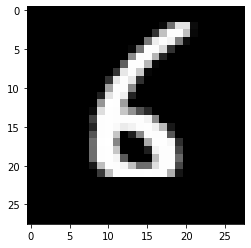

In [116]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(2)

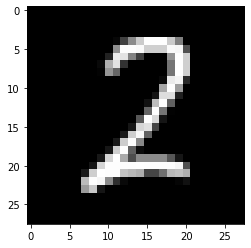

In [117]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

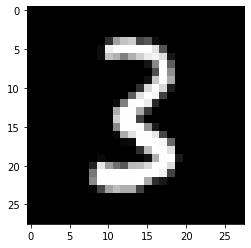

In [118]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

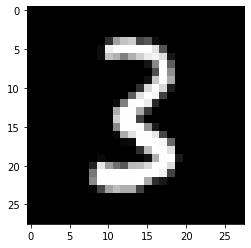

In [120]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [121]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1439, grad_fn=<NllLossBackward>), tensor(0.9375))

The pytorch datloader does ecxactly that.

### PyTorch DataLoader

In [122]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [123]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(train_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [124]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0683, grad_fn=<NllLossBackward>), tensor(1.))

Pytorch's defaults works fine for most things however

drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

In [125]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=True)

In [126]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0781, grad_fn=<NllLossBackward>), tensor(1.))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [127]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # handle batchnorm/Dropout
        model.train()
        #print(model.training)
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        #print(model.training)
        with torch.no_grad():
            tot_loss, tot_acc = 0.,0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        # incorrect way if batch size varies. Will lower loss and accuracy.
        # However that it is not how fastai does it.
    return tot_loss/nv, tot_acc/nv

Why do you need a model.train and model.eval?  
All it does is set an internal attribute called *model.training* to true or False. WHy would you need that? Because some layers need to act differently depending on its training & evaluation. For eg: BatchNorm only updates its running statistics when training; Dropout only acts when in training etc.  
  
If you forget to set to eval mode when you're done training you'll often be surprised because of worse than expected results. So remember to check that.

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [128]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
           DataLoader(valid_ds, batch_size= bs*2, shuffle=False, **kwargs))

We don't have to calculate the gradients for the validation set and so as we have twice as much room, we double its batch size.

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [129]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3610) tensor(0.8966)
1 tensor(0.2258) tensor(0.9329)
2 tensor(0.1047) tensor(0.9684)
3 tensor(0.1025) tensor(0.9698)
4 tensor(0.1261) tensor(0.9647)


In [130]:
assert acc>0.9

## Export

In [122]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp\nb_03.py
